In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df_gasolina = pd.read_pickle('data_unificados.pkl')
df_gasolina_sem = df_gasolina.resample('W', on='data_da_coleta').mean().reset_index()
df_gasolina_sem.rename(columns={'data_da_coleta': 'data'}, inplace=True)

In [17]:
print(df_gasolina_sem.head())

        data  valor_de_venda  valor_de_compra     ano  mes  dia_da_semana
0 2014-01-05        2.554779         2.200204  2014.0  1.0       3.462280
1 2014-01-12        2.561007         2.220306  2014.0  1.0       1.062514
2 2014-01-19        2.563677         2.227961  2014.0  1.0       1.477949
3 2014-01-26        2.565591         2.227089  2014.0  1.0       1.406349
4 2014-02-02        2.567290         2.232623  2014.0  1.0       1.247773


In [18]:
df_petroleo = pd.read_pickle('dataset/dados_petroleo_semanal.pkl')
df_petroleo['Data'] = pd.to_datetime(df_petroleo['Data'], errors='coerce')
df_petroleo.rename(columns={'Data': 'data', 'Último': 'petroleo_ultimo', 'Var%': 'petroleo_var'}, inplace=True)
print(df_petroleo.head())

        data  petroleo_ultimo  Abertura  Máxima  Mínima  Vol.  petroleo_var
0 2023-12-31            78.76     77.39   79.41   74.79   NaN          2.23
1 2023-12-24            77.04     79.04   81.72   76.73   NaN         -2.57
2 2023-12-17            79.07     76.80   80.60   75.76   NaN          3.29
3 2023-10-12            76.55     75.73   77.35   72.29   NaN          0.94
4 2023-03-12            75.84     79.50   79.72   73.60   NaN         -3.85


In [19]:
df_usd = pd.read_pickle('dataset/dados_usd_brl_semanal.pkl')
df_usd['Data'] = pd.to_datetime(df_usd['Data'], errors='coerce')
df_usd.rename(columns={'Data': 'data', 'Último': 'usd_ultimo', 'Var%': 'usd_var'}, inplace=True)
print(df_usd.head())

        data  usd_ultimo  Abertura  Máxima  Mínima  Vol.  usd_var
0 2023-12-31      4.8743    4.8534  4.9407  4.8489   NaN     0.46
1 2023-12-24      4.8521    4.8513  4.8714  4.8018   NaN    -0.13
2 2023-12-17      4.8585    4.9414  4.9520  4.8481   NaN    -1.59
3 2023-10-12      4.9371    4.9268  4.9773  4.8749   NaN     0.11
4 2023-03-12      4.9317    4.8780  4.9680  4.8780   NaN     1.06


In [14]:
df_producao = pd.read_pickle('dataset/producao-petroleo-m3-1997-2025_tratado.pkl')
df_producao['data'] = pd.to_datetime(df_producao['ano'].astype(str) + '-' + df_producao['mês'].astype(str) + '-01', errors='coerce')
df_producao.set_index('data', inplace=True)
df_producao_unique = df_producao.groupby(df_producao.index).mean()


df_producao_sem = df_producao_unique.resample('W').ffill().reset_index()

print(df_producao_sem.head())

        data     ano       producao
0 1997-01-05  1997.0  179697.590909
1 1997-01-12  1997.0  179697.590909
2 1997-01-19  1997.0  179697.590909
3 1997-01-26  1997.0  179697.590909
4 1997-02-02  1997.0  179697.590909


In [20]:
df_final = df_gasolina_sem.merge(df_petroleo, on='data', how='left') \
                          .merge(df_usd, on='data', how='left') \
                          .merge(df_producao_sem[['data', 'producao']], on='data', how='left')

selected_columns = ['data', 'valor_de_venda', 'petroleo_ultimo', 'petroleo_var', 'usd_ultimo', 'usd_var', 'producao']
df_modelo = df_final[selected_columns].copy()

In [21]:
print(df_modelo.head())
print(df_modelo.info())

        data  valor_de_venda  petroleo_ultimo  petroleo_var  usd_ultimo  \
0 2014-01-05        2.554779              NaN           NaN         NaN   
1 2014-01-12        2.561007              NaN           NaN         NaN   
2 2014-01-19        2.563677           107.88          1.31      2.3982   
3 2014-01-26        2.565591           106.40         -1.37      2.4127   
4 2014-02-02        2.567290           109.57          2.98      2.3802   

   usd_var       producao  
0      NaN  459828.176482  
1      NaN  459828.176482  
2     2.37  459828.176482  
3     0.60  459828.176482  
4    -1.35  459828.176482  
<class 'pandas.core.frame.DataFrame'>
Int64Index: 575 entries, 0 to 574
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   data             575 non-null    datetime64[ns]
 1   valor_de_venda   533 non-null    float64       
 2   petroleo_ultimo  343 non-null    float64       
 3   petrole

In [23]:
df_modelo.to_csv('dados_modelo_final.csv')

In [24]:
df_modelo = pd.read_pickle('dados_modelo_final.pkl')
print(df_modelo.isna().sum())

data                 0
valor_de_venda      42
petroleo_ultimo    232
petroleo_var       232
usd_ultimo         232
usd_var            232
producao             0
dtype: int64


In [28]:
colunas_para_interpolar = ['valor_de_venda','petroleo_ultimo', 'petroleo_var', 'usd_ultimo', 'usd_var']
df_modelo[colunas_para_interpolar] = df_modelo[colunas_para_interpolar].interpolate(method='linear')
df_modelo[colunas_para_interpolar] = df_modelo[colunas_para_interpolar].fillna(method='ffill').fillna(method='bfill')
print(df_modelo[colunas_para_interpolar].isna().sum())

valor_de_venda     0
petroleo_ultimo    0
petroleo_var       0
usd_ultimo         0
usd_var            0
dtype: int64


In [30]:
df_modelo.to_pickle('dados_modelo_final.pkl')
df_modelo.to_csv('dados_modelo_final.csv')

In [32]:
df_modelo  = pd.read_pickle('dados_modelo_final.pkl')
df_modelo .info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 575 entries, 0 to 574
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   data             575 non-null    datetime64[ns]
 1   valor_de_venda   575 non-null    float64       
 2   petroleo_ultimo  575 non-null    float64       
 3   petroleo_var     575 non-null    float64       
 4   usd_ultimo       575 non-null    float64       
 5   usd_var          575 non-null    float64       
 6   producao         575 non-null    float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 35.9 KB


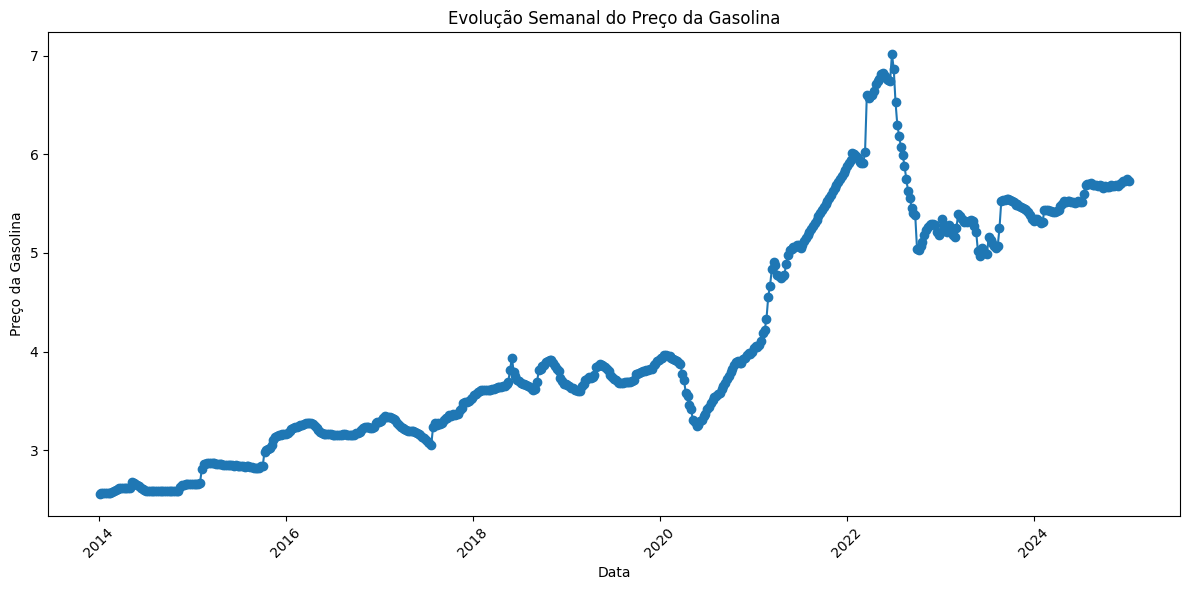

In [ ]:
#Evolução do Preço da Gasolina
plt.figure(figsize=(12,6))
plt.plot(df_modelo['data'], df_modelo['valor_de_venda'], marker='o', linestyle='-')
plt.xlabel('Data')
plt.ylabel('Preço da Gasolina')
plt.title('Evolução Semanal do Preço da Gasolina')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

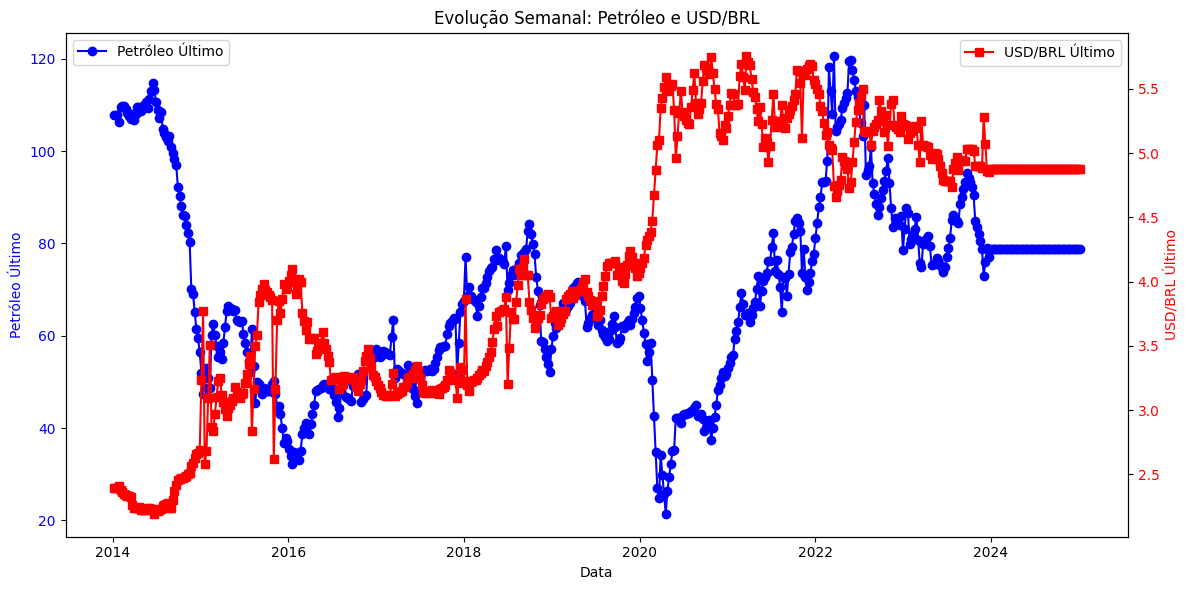

In [38]:
#Evolução do Petróleo e do USD/BRL com Eixos Duplos
fig, ax1 = plt.subplots(figsize=(12,6))

# Eixo esquerdo: Petróleo
ax1.plot(df_modelo['data'], df_modelo['petroleo_ultimo'], marker='o', color='blue', label='Petróleo Último')
ax1.set_xlabel('Data')
ax1.set_ylabel('Petróleo Último', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend(loc='upper left')

# Eixo direito: USD/BRL
ax2 = ax1.twinx()
ax2.plot(df_modelo['data'], df_modelo['usd_ultimo'], marker='s', color='red', label='USD/BRL Último')
ax2.set_ylabel('USD/BRL Último', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.legend(loc='upper right')

plt.title('Evolução Semanal: Petróleo e USD/BRL')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

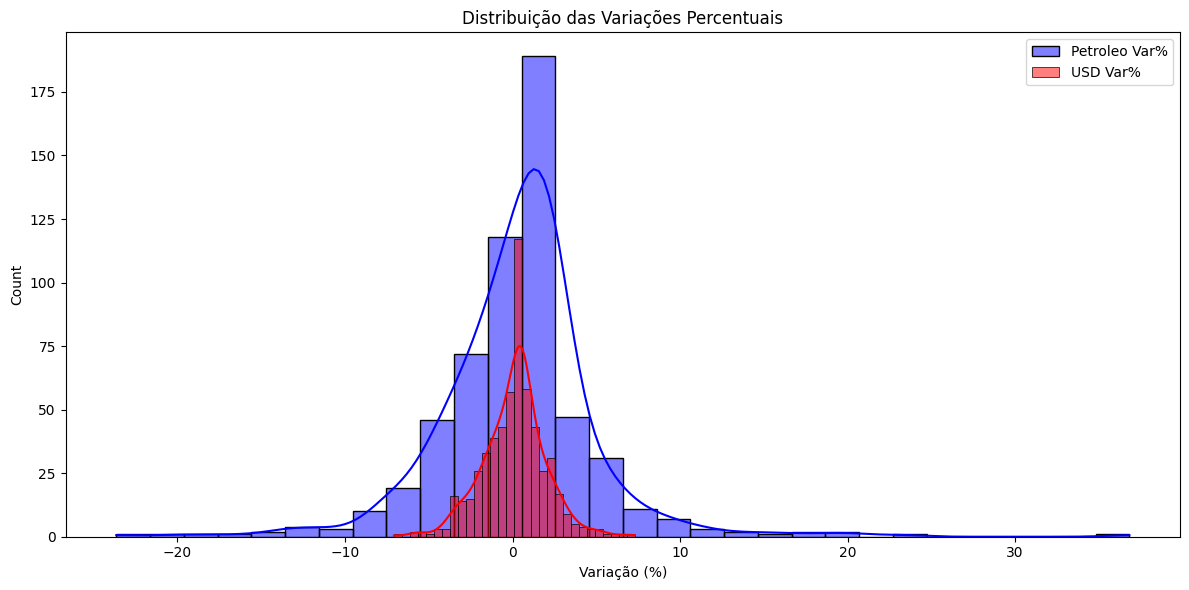

In [39]:
#Distribuição das Variações Percentuais (Petróleo e USD)
plt.figure(figsize=(12,6))
sns.histplot(df_modelo['petroleo_var'].dropna(), bins=30, kde=True, color='blue', label='Petroleo Var%')
sns.histplot(df_modelo['usd_var'].dropna(), bins=30, kde=True, color='red', label='USD Var%', alpha=0.5)
plt.xlabel('Variação (%)')
plt.title('Distribuição das Variações Percentuais')
plt.legend()
plt.tight_layout()
plt.show()

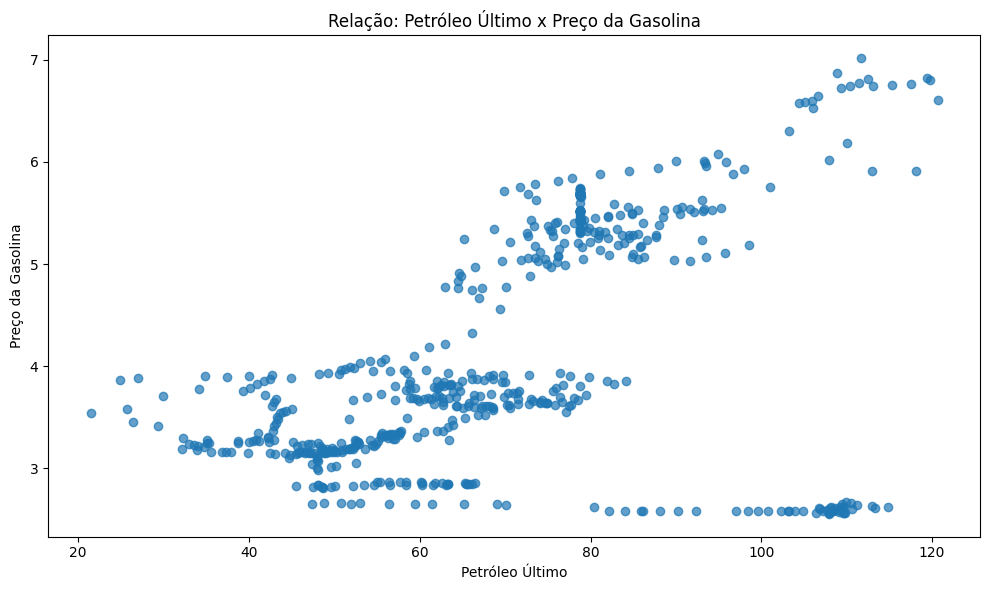

In [40]:
#Relação entre Petróleo Último e Preço da Gasolina
plt.figure(figsize=(10,6))
plt.scatter(df_modelo['petroleo_ultimo'], df_modelo['valor_de_venda'], alpha=0.7)
plt.xlabel('Petróleo Último')
plt.ylabel('Preço da Gasolina')
plt.title('Relação: Petróleo Último x Preço da Gasolina')
plt.tight_layout()
plt.show()

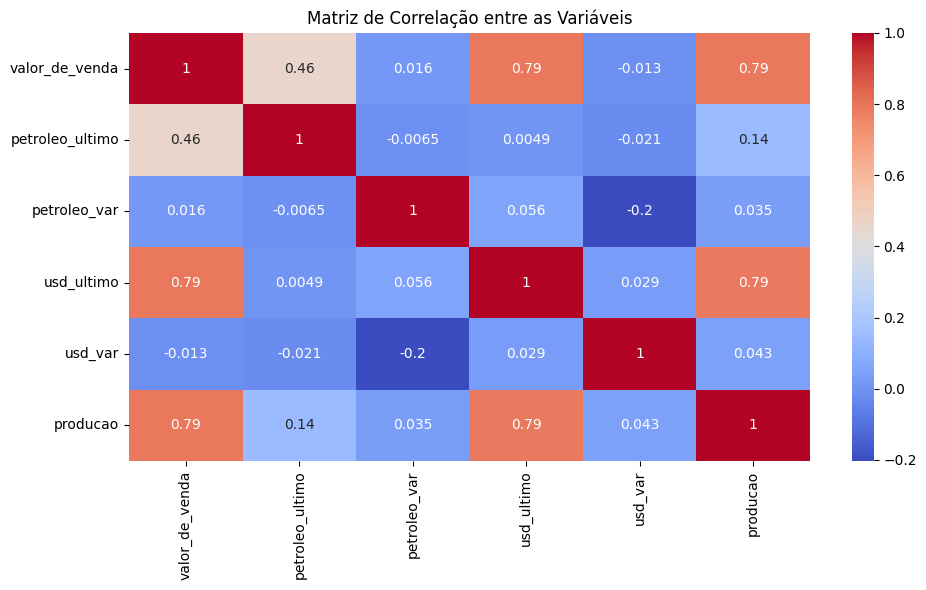

In [41]:
#Matriz de Correlação entre as Variáveis
corr = df_modelo[['valor_de_venda', 'petroleo_ultimo', 'petroleo_var', 'usd_ultimo', 'usd_var', 'producao']].corr()
plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlação entre as Variáveis')
plt.tight_layout()
plt.show()